In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy.stats import norm, triang, uniform
import matplotlib.pyplot as plt
from scipy.stats import norm

# Quantitative Risk Assessment Techniques

## 1. Probability Analysis
This case models a company's concern about the risk of a competitor entering its market. 

To quantify this risk, we use a combination of expert opinion and historical data. 
- Expert assessments are collected using the Delphi method, which yields a prior belief of approximately 30% chance of competitor entry, modeled using a Beta(3, 7) distribution to reflect moderate confidence.
    - The mean of Beta distribution is $$(\alpha + \beta) / \alpha$$
- Historical data shows that in 5 out of 12 similar market situations, competitors successfully entered. Using Bayesian inference, we update our beliefs by combining this data with our prior.
- The result is a posterior distribution representing the updated probability of competitor entry.
- We visualize this using a density plot and note that the model is flexible—allowing us to adjust the prior based on new scenarios or assumptions, such as economic shocks or regulatory changes.

In [2]:
# Step 1: Prior beliefs from Delphi Method (e.g., 3 experts)
# Expert consensus: ~30% chance of competitor entry, moderate confidence
alpha_prior = 3
beta_prior = 7  # Beta(3,7) has a mean of 0.3

In [3]:
# Step 2: Historical data (e.g., 5 out of 12 similar cases had entries)
historical_entries = 5
historical_total = 12

#### obs = pm.Binomial('obs', n=historical_total, p=theta, observed=historical_entries)

- Defines the likelihood function for the observed data.
- Uses a Binomial distribution (appropriate for count data where you have successes out of trials).
- n=historical_total: Total number of trials.
- p=theta: Probability of success (our parameter we're estimating).
- observed=historical_entries: The actual observed success count (data).

#### trace = pm.sample(2000, tune=1000, cores=1, return_inferencedata=True)

- Runs the MCMC (Markov Chain Monte Carlo) sampling to approximate the posterior distribution.
- 2000: Draws 2000 samples from the posterior.
- tune=1000: Uses 1000 tuning steps to adjust sampling parameters (discarded).
- cores=1: Uses 1 CPU core.
- return_inferencedata=True: Returns results in ArviZ's InferenceData format (for better diagnostics).

In [4]:
# Step 3: Define Bayesian model
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=alpha_prior, beta=beta_prior) #Defines a prior distribution for the parameter theta (which represents a probability). Beta distribution is a common choice for probabilities.
    obs = pm.Binomial('obs', n=historical_total, p=theta, observed=historical_entries)
    trace = pm.sample(2000, tune=1000, cores=1, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


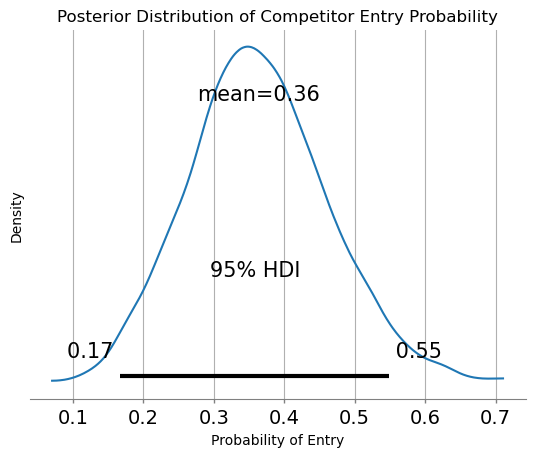

In [5]:
# Step 4: Plot posterior distribution
az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95)
plt.title("Posterior Distribution of Competitor Entry Probability")
plt.xlabel("Probability of Entry")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Step 5: Simulate impact of new scenario (e.g., a market shock reduces chances)
# Adjust prior to Beta(2, 8) and rerun if needed

#### Interpretation of the graph:

- The posterior distribution is the updated belief about the competitor's entry probability after combining prior beliefs (expert opinions) with observed data.
- Mean (0.36):
    - The average posterior probability of competitor entry is 36%.
    - This is the Bayesian "best estimate" after updating prior beliefs with data.
- 95% HDI (Highest Density Interval):
    - The shaded region spans 0.17 to 0.55.
    - Interpretation: "There’s a 95% probability the true entry probability lies between 17% and 55%."

## 2. Modelling and Financial Metrics

#### 2.1 Sensitivity Analysis:

Create a tornado diagram showing sensitivity of drug NPV to market size (±10%), price (±10%), and R&D cost (±10%).


Tornado graph: 
- A visualization tool that helps understand the impact of different variables on a specific outcome.
- It's commonly used in sensitivity analysis to identify which variables have the most significant influence on a result. 

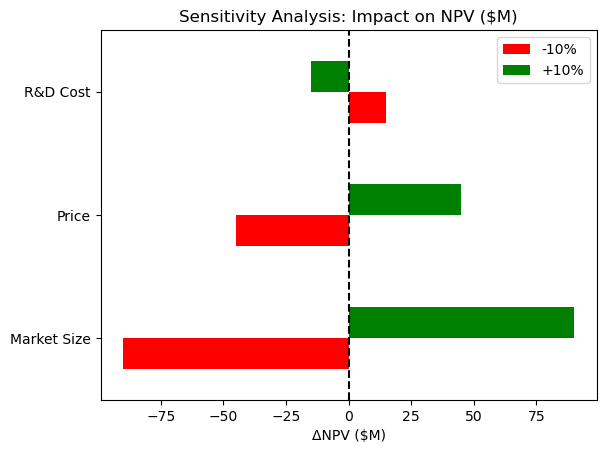

In [10]:
def sensitivity_analysis():
    # Base case NPV
    base_npv = 1500  # $M
    
    # Parameters and their impacts (±10% perturbation)
    params = {
        "Market Size": {"range": [0.9, 1.1], "impact": 0.6}, 
        "Price": {"range": [0.9, 1.1], "impact": 0.3},
        "R&D Cost": {"range": [1.1, 0.9], "impact": 0.1}  # Note: R&D cost inversely affects NPV
    }
    
    # Calculate NPV changes for each parameter
    results = {
        param: [
            base_npv * v["impact"] * (v["range"][0] - 1),  # Lower bound (-10%)
            base_npv * v["impact"] * (v["range"][1] - 1)   # Upper bound (+10%)
        ]
        for param, v in params.items()
    }
    
    # Create DataFrame with explicit index
    df = pd.DataFrame(results, index=["-10%", "+10%"])
    
    # Plot tornado diagram
    df.T.plot(kind="barh", color=["red", "green"])
    plt.title("Sensitivity Analysis: Impact on NPV ($M)")
    plt.xlabel("ΔNPV ($M)")
    plt.axvline(0, color="black", linestyle="--")
    plt.show()

sensitivity_analysis()

#### Interpretation of the tornado graph:
- Market Size:
    - Largest impact on NPV.
    - A 10% decrease in market size reduces NPV by almost $90M.
    - A 10% increase raises it by a similar amount.

    👉 This is the most sensitive variable; small changes have big effects.

- Price:
    - Moderately sensitive.
    - A ±10% change in price causes a change of around $50M in NPV.

    👉 Price strategy should be carefully considered.

- R&D Cost:
    - Least sensitive among the three.
    - Changes in R&D cost impact NPV by ~$10M either way.

    👉 Variations in R&D cost are relatively less critical to NPV.

#### 2.2 Expected Monetary Value

#### Example 1

You have the option to invest \\$100 in a stock that has a 50% chance of increasing in value by \\$100 and a 50% chance of decreasing in value by \\$50. 

The EMV of this decision is calculated as follows:

In [14]:
def calculate_emv_1():
    risks = {
        "Stock Increase": {"prob": 0.5, "impact": 100},
        "Stock Decrease": {"prob": 0.5, "impact": -50}
    }

    total_emv = 0
    for risk, v in risks.items():
        emv = v["prob"] * v["impact"]
        total_emv += emv
        print(f"{risk}: EMV = ${emv}")

    print(f"Total EMV = ${total_emv}")

calculate_emv_1()

Stock Increase: EMV = $50.0
Stock Decrease: EMV = $-25.0
Total EMV = $25.0


#### Example 2

Prioritize risks in the supply chain.

In [15]:
def calculate_emv_2():
    risks = {
        "Material Shortage": {"prob": 0.2, "impact": 300},
        "Manufacturing Delay": {"prob": 0.3, "impact": 150}
    }
    for risk, v in risks.items():
        emv = v["prob"] * v["impact"]
        print(f"{risk}: EMV = ${emv}M")

calculate_emv_2()

Material Shortage: EMV = $60.0M
Manufacturing Delay: EMV = $45.0M


#### Interpretation of above results:

- Example 1: You are expected to gain $25 from this investment. 
- Example 2: Mitigate material shortage first (higher EMV).

# Risk Exposure
## Value at Risk (VaR)

In [2]:
# Define returns
returns = np.random.normal(0.001, 0.02, 1000)  # Mean=0.1%, Volatility=2%

def historical_var(returns, confidence=0.95):
    var = np.percentile(returns, 100 * (1 - confidence))
    return var
    
def parametric_var(returns, confidence=0.95):
    """Compute VaR using normal distribution assumption."""
    mean = returns.mean()
    std_dev = returns.std()
    z_score = norm.ppf(1 - confidence)
    var = mean + z_score * std_dev
    return var

def monte_carlo_var(returns, confidence=0.95, n_simulations=10000):
    """Compute VaR using Monte Carlo simulation."""
    log_returns = np.log(1 + returns)
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    # Simulate future returns
    simulated_returns = np.random.normal(mu, sigma, n_simulations)
    var = np.percentile(simulated_returns, 100 * (1 - confidence))
    return np.exp(var) - 1  # Convert log-return to simple return
    
var_hist = historical_var(returns, 0.95)
var_param = parametric_var(returns, 0.95)
var_mc = monte_carlo_var(returns, 0.95)
print(f"95% Historical VaR: {var_hist:.2%}")
print(f"95% Parametric VaR: {var_param:.2%}")
print(f"95% Monte Carlo VaR: {var_mc:.2%}")

95% Historical VaR: -3.31%
95% Parametric VaR: -3.30%
95% Monte Carlo VaR: -3.29%


# Risk Mitigation Measures

## Contingency Planning

Based on a competitor entry probability of 35% and a potential revenue loss of $10M, estimate the contingency reserve needed if mitigation measures are 60% effective.

$$\text{Contingency} = \text{Risk Exposure} \times \text{Mitigation Efficacy}$$

Risk Exposure = \\$10M × 35% = \\$3.5M  
Contingency = \\$3.5M × 60% = \\$2.1M  

Recommendation: Allocate a $2.1M contingency reserve to mitigate the competitive threat.


## Optimization

Given projected returns and covariances of business units, optimize the resource allocation to minimize competitor concentration risk using a Markowitz efficient frontier approach.

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOG"]
data = yf.download(tickers, start="2020-01-01", end="2024-01-01") #["Adj Close"]

price_data = data['Close']

#Calculates the expected annual return (mean) for each asset using historical prices.
#Assumes daily data and annualizes it using compounding.
mu = mean_historical_return(price_data)

#Estimates the annualized covariance matrix of asset returns.
#Uses the Ledoit-Wolf shrinkage method, 
#which stabilizes covariance estimation (less sensitive to outliers and noise than plain sample covariance).
S = CovarianceShrinkage(price_data).ledoit_wolf()

#Constructs a mean-variance optimizer.
ef = EfficientFrontier(mu, S)

#min_volatility() tells it to find the portfolio weights that 
#minimize total portfolio risk (volatility), without considering return.
weights = ef.min_volatility()

#Calculates and prints portfolio performance metrics:
# - Expected annual return
# - Annual volatility
# - Sharpe ratio (risk-adjusted return)
ef.portfolio_performance(verbose=True)

[*********************100%***********************]  3 of 3 completed

Expected annual return: 24.0%
Annual volatility: 30.1%
Sharpe Ratio: 0.80


(np.float64(0.24017854707929176),
 np.float64(0.3009879123495945),
 np.float64(0.7979674173769701))

In [29]:
#To check the weights of my portfolio.

weights_df = pd.Series(weights).sort_values(ascending=False)
print(weights_df)

GOOG    0.346827
AAPL    0.330521
MSFT    0.322652
dtype: float64


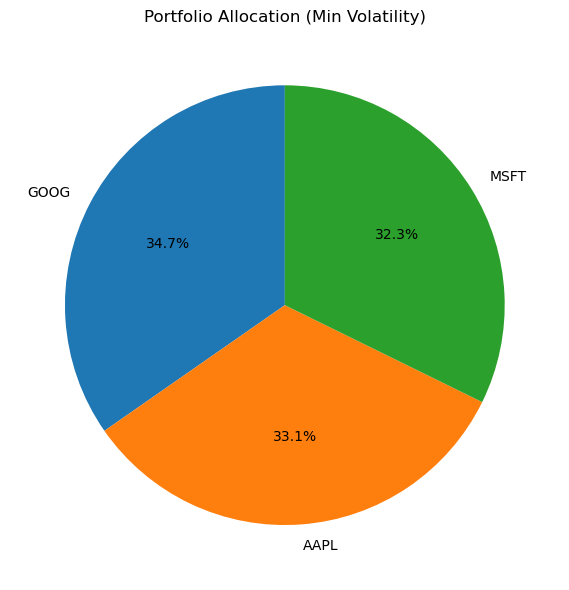

In [30]:
#Pie chart
weights_df.plot.pie(autopct='%1.1f%%', figsize=(6, 6), startangle=90)
plt.title("Portfolio Allocation (Min Volatility)")
plt.ylabel("")  # hide y-label
plt.tight_layout()
plt.show()

#### Interpretation of above results:

- Your portfolio is expected to return ~24% per year on average, based on historical data.
- 30% is relatively high volatility — typical of equity-heavy portfolios.
- 0.80 is moderate — generally:

    - < 1.0 = OK
    - 1.0–2.0 = good
    - 2.0 = excellent